# Gesture Recognition
In this group project, we are going to build a model that will be able to predict the 5 gestures correctly. 

In [1]:
import numpy as np
import os
from imageio.v2 import imread
import cv2
import datetime
import os
import matplotlib.pyplot as plt
import random
from PIL import Image,ImageFilter, ImageEnhance

import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf

In this block, we read the folder names for training and validation. 

In [3]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

## Generator
This is one of the most important part of the code where data for both training and validation set is loaded from given data set

In [4]:
def process_batch(source_path,t,num_batches,img_idx,img_x,img_y,batch_size,remaining_seq=0):
    batch_count = remaining_seq if remaining_seq else batch_size
    
    batch_data = np.zeros((batch_count,len(img_idx),img_x,img_y,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_count,5)) # batch_labels is the one hot representation of the output
    for folder in range(batch_count): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
#         imgs=sorted(imgs)
        for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
            image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
            if image.shape[1] > image.shape[0]:
                diff_px = image.shape[1] - image.shape[0]
                crop_start = diff_px//2
                crop_end = crop_start + image.shape[0]
                image = image[:, crop_start:crop_end]
            elif image.shape[0] > image.shape[1]:
                diff_px = image.shape[0] - image.shape[1]
                crop_start = diff_px//2
                crop_end = crop_start + image.shape[1]
                image = image[:, crop_start:crop_end]
                
            resized_image = cv2.resize(image,(img_x,img_y)).astype(np.float32)
            
            batch_data[folder,idx,:,:,0] = resized_image[:,:,0] - 104
            batch_data[folder,idx,:,:,1] = resized_image[:,:,1] - 117
            batch_data[folder,idx,:,:,2] = resized_image[:,:,2] - 123
        batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
    return (batch_data,batch_labels)
    

In [5]:
def generator(source_path, folder_list, batch_size,img_idx,img_x,img_y):
    #experiment with all,even,odd and skip initial and last
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size
        count = 0
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data, batch_labels = process_batch(source_path,t,batch,img_idx,img_x,img_y,batch_size)
            yield batch_data, batch_labels
        
        remaining_seq=len(t)%batch_size
        if(remaining_seq != 0):
            batch_data, batch_labels = process_batch(source_path,t,num_batches,img_idx,img_x,img_y,batch_size,remaining_seq)
            yield batch_data, batch_labels


In [6]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [7]:
def data_generator(img_idx,img_x,img_y,batch_size):
    train_generator = generator(train_path, train_doc, batch_size,img_idx,img_x,img_y)
    val_generator = generator(val_path, val_doc, batch_size,img_idx,img_x,img_y)
    return train_generator,val_generator

## Model

In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, ConvLSTM2D, GlobalAveragePooling2D, GlobalAveragePooling3D
from keras.layers.convolutional import Conv3D, MaxPooling3D, MaxPooling2D, Conv2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout
from tensorflow.keras.optimizers import SGD,Adam

## Conv3D - NO Dropouts

In [9]:
def conv3d_1(input_shape,optimiser):
    model = Sequential()
    model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling3D(pool_size=2))

    model.add(Conv3D(64, kernel_size=3, activation='relu'))
    model.add(MaxPooling3D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    
    if(optimiser == 'SGD'):
        opt = SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
    else:
        opt = Adam(lr=0.001, decay=1e-6)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())
    return model

## Conv3D - With Dropouts

In [10]:
def conv3d_2(input_shape,optimiser,dropout):
    model = Sequential()
    model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

    model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

    model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

    model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

    model.add(Flatten())
    model.add(Dropout(dropout))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(5, activation='softmax'))
    
    if(optimiser == 'SGD'):
        opt = SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
    else:
        opt = Adam(lr=0.001, decay=1e-6)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())
    return model

## Conv2D + LSTM

In [11]:
def conv2d_lstm_1(input_shape,optimiser):
    model = Sequential()
    model.add(TimeDistributed(
        Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
    )
    model.add(BatchNormalization())
    model.add(TimeDistributed(
        Conv2D(16, (3,3), activation='relu'))
    )
    model.add(BatchNormalization())
    model.add(
        ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
    )
    model.add(BatchNormalization())
    model.add(TimeDistributed(
        Dense(64, activation='relu'))
    )
    model.add(BatchNormalization())
    model.add(GlobalAveragePooling2D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    
    if(optimiser == 'SGD'):
        opt = SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
    else:
        opt = Adam(lr=0.001, decay=1e-6)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())
    return model

## Conv2D + GRU

In [12]:
def conv2d_gru_1(input_shape,optimiser,dropout):
    model = Sequential()
    model.add(TimeDistributed(
        Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
    )
    model.add(TimeDistributed(
        MaxPooling2D((2,2)))
    )
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(TimeDistributed(
        Conv2D(64, (3,3), activation='relu'))
    )
    model.add(TimeDistributed(
        MaxPooling2D((2,2)))
    )
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(TimeDistributed(GlobalAveragePooling2D()))
    model.add(TimeDistributed(Dense(64, activation='relu')))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(GRU(128))
    model.add(BatchNormalization())
    model.add(Dense(5, activation='softmax'))
    
    if(optimiser == 'SGD'):
        opt = SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
    else:
        opt = Adam(lr=0.001, decay=1e-6)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())
    return model

## Conv2D + Dense

In [13]:
def conv2d_dense_1(input_shape,optimiser,dropout):
    model = Sequential()
    model.add(TimeDistributed(
        Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
    )
    model.add(TimeDistributed(
        MaxPooling2D((2,2)))
    )
    model.add(BatchNormalization())

    model.add(TimeDistributed(
        Conv2D(64, (3,3), activation='relu'))
    )
    model.add(TimeDistributed(
        MaxPooling2D((2,2)))
    )
    model.add(BatchNormalization())

    model.add(TimeDistributed(
        Conv2D(128, (3,3), activation='relu'))
    )
    model.add(TimeDistributed(
        MaxPooling2D((2,2)))
    )
    model.add(BatchNormalization())

    model.add(GlobalAveragePooling3D())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(5, activation='softmax'))
    
    if(optimiser == 'SGD'):
        opt = SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
    else:
        opt = Adam(lr=0.001, decay=1e-6)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())
    return model

## Conv2D + LSTM2D

In [14]:
def conv2d_LSTM2D_1(input_shape,optimiser):
    model = Sequential()
    model.add(TimeDistributed(
        Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
    )
    model.add(BatchNormalization())
    model.add(TimeDistributed(
        Conv2D(16, (3,3), activation='relu'))
    )
    model.add(BatchNormalization())
    model.add(
        ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
    )
    model.add(BatchNormalization())
    model.add(TimeDistributed(
        Dense(64, activation='relu'))
    )
    model.add(BatchNormalization())
    model.add(GlobalAveragePooling2D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    
    if(optimiser == 'SGD'):
        opt = SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
    else:
        opt = Adam(lr=0.001, decay=1e-6)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())
    return model

In [15]:
def define_checkpoint_callback():
    model_name = 'model_'+experiment_name + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + experiment_number+'-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
    callbacks_list = [checkpoint, LR]
    return callbacks_list

In [16]:
def epoch_steps():
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    return steps_per_epoch, validation_steps

In [17]:
def modelplot(history): 
    plt.figure(figsize=(20,6))
    ax1 = plt.subplot(121)
    ax1 = plt.plot(history.history['loss'])
    ax1 = plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower left')
    ax2 = plt.subplot(122)
    ax2 = plt.plot(history.history['categorical_accuracy'])
    ax2 = plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('categorical_accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower left')
    plt.show()

Let us now fit the model. This will start training the model and with the help of the checkpoints, we will be able to save the model at the end of each epoch.

## Experiment 1 
<b>Conv3D: NO Dropouts</b> - 
All Images | Batch Size = 10 | Optimizer = SGD | Number of Epochs = 5

# batch_size = 10
# epochs = 5
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 27, 78, 78, 32)    2624      
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 13, 39, 39, 32)   0         
 3D)                                                             
                                                                 
 conv3d_3 (Conv3D)           (None, 11, 37, 37, 64)    55360     
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 5, 18, 18, 64)    0         
 3D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 103680)            0         
                                                                 
 dense_2 (Dense)       

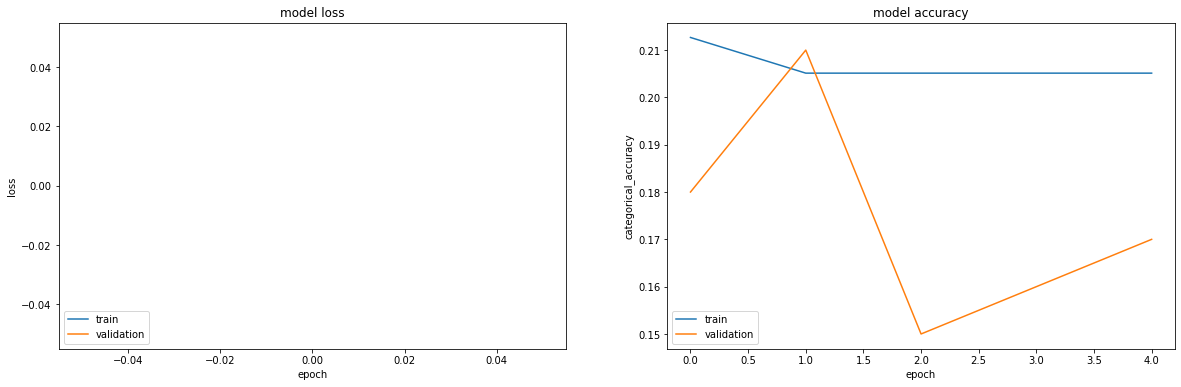

In [35]:
#Hyperparameters
batch_size = 10
num_epochs = 5

print ('# batch_size =', batch_size)
print ('# epochs =', num_epochs)

experiment_name = 'Conv3D'
experiment_number = 'Experiment_1'
img_x = 80
img_y = 80
img_idx = range(0,29)
input_shape = (len(img_idx),img_x,img_y,3)

#Data Generator
train_generator,val_generator = data_generator(img_idx,img_x,img_y,batch_size)

#Create the model
model = conv3d_1(input_shape,'SGD')
callbacks_list = define_checkpoint_callback()

steps_per_epoch, validation_steps = epoch_steps()

#Fit the model'
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
#Plot the results
modelplot(history)

## Experiment 2 
<b>Conv3D: NO Dropouts</b> - 
All Images | Batch Size = 16 | Optimizer = SGD | Number of Epochs = 5

# batch_size = 16
# epochs = 5
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 27, 78, 78, 32)    2624      
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 13, 39, 39, 32)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 11, 37, 37, 64)    55360     
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 5, 18, 18, 64)    0         
 3D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 103680)            0         
                                                                 
 dense_4 (Dense)       

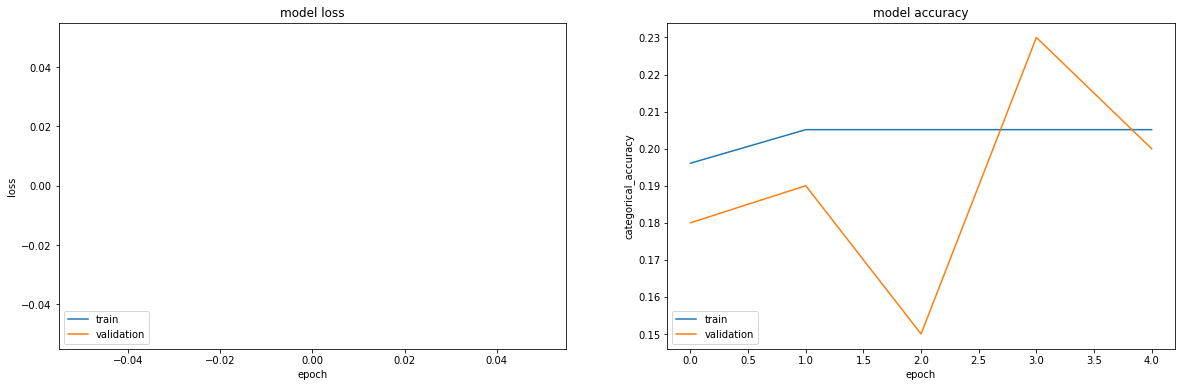

In [36]:
#Hyperparameters
batch_size = 16
num_epochs = 5

print ('# batch_size =', batch_size)
print ('# epochs =', num_epochs)

experiment_name = 'Conv3D'
experiment_number = 'Experiment_2'
img_x = 80
img_y = 80
img_idx = range(0,29)
input_shape = (len(img_idx),img_x,img_y,3)

#Data Generator
train_generator,val_generator = data_generator(img_idx,img_x,img_y,batch_size)

#Create the model
model = conv3d_1(input_shape,'SGD')
callbacks_list = define_checkpoint_callback()
steps_per_epoch, validation_steps = epoch_steps()

#Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
#Plot the results
modelplot(history)

## Experiment 3 
<b>Conv3D: NO Dropouts</b> - 
All Images | Batch Size = 20 | Optimizer = SGD | Number of Epochs = 5

# batch_size = 20
# epochs = 5
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 27, 78, 78, 32)    2624      
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 13, 39, 39, 32)   0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 11, 37, 37, 64)    55360     
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 5, 18, 18, 64)    0         
 3D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 103680)            0         
                                                                 
 dense_6 (Dense)       

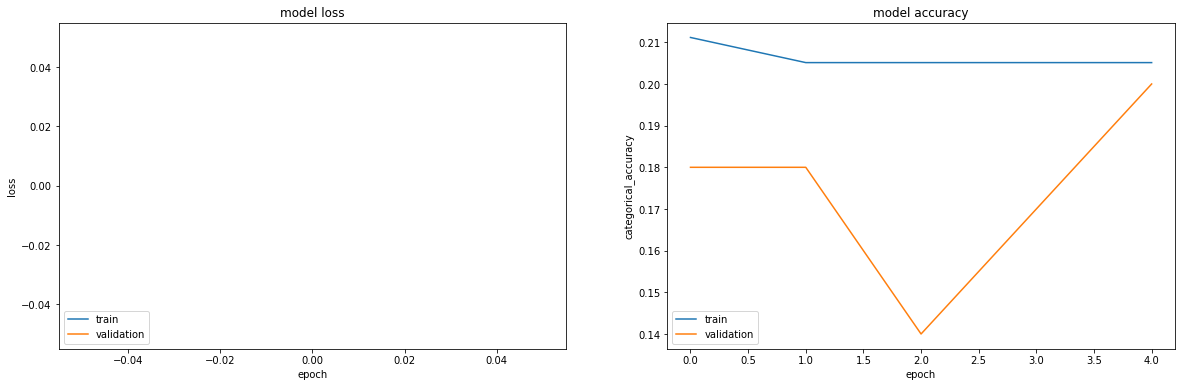

In [37]:
#Hyperparameters
batch_size = 20
num_epochs = 5

print ('# batch_size =', batch_size)
print ('# epochs =', num_epochs)

experiment_name = 'Conv3D'
experiment_number = 'Experiment_3'
img_x = 80
img_y = 80
img_idx = range(0,29)
input_shape = (len(img_idx),img_x,img_y,3)

#Data Generator
train_generator,val_generator = data_generator(img_idx,img_x,img_y,batch_size)

#Create the model
model = conv3d_1(input_shape,'SGD')
callbacks_list = define_checkpoint_callback()
steps_per_epoch, validation_steps = epoch_steps()

#Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
#Plot the results
modelplot(history)

## Experiment 4 
<b>Conv3D: NO Dropouts</b> - 
All Images | Batch Size = 32 | Optimizer = SGD | Number of Epochs = 5

# batch_size = 32
# epochs = 5
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 27, 78, 78, 32)    2624      
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 13, 39, 39, 32)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 11, 37, 37, 64)    55360     
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 5, 18, 18, 64)    0         
 3D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 103680)            0         
                                                                 
 dense_8 (Dense)       

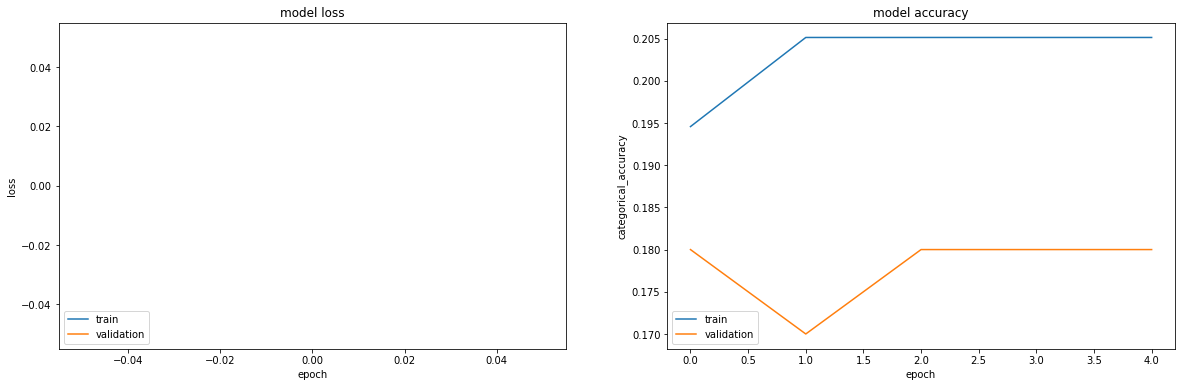

In [38]:
#Hyperparameters
batch_size = 32
num_epochs = 5

print ('# batch_size =', batch_size)
print ('# epochs =', num_epochs)

experiment_name = 'Conv3D'
experiment_number = 'Experiment_4'
img_x = 80
img_y = 80
img_idx = range(0,29)
input_shape = (len(img_idx),img_x,img_y,3)

#Data Generator
train_generator,val_generator = data_generator(img_idx,img_x,img_y,batch_size)

#Create the model
model = conv3d_1(input_shape,'SGD')
callbacks_list = define_checkpoint_callback()
steps_per_epoch, validation_steps = epoch_steps()

#Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
#Plot the results
modelplot(history)

## Experiment 5 
<b>Conv3D: NO Dropouts</b> - 
All Images | Batch Size = 32 | Optimizer = Adam | Number of Epochs = 10

# batch_size = 32
# epochs = 10
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_10 (Conv3D)          (None, 27, 78, 78, 32)    2624      
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 13, 39, 39, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_11 (Conv3D)          (None, 11, 37, 37, 64)    55360     
                                                                 
 max_pooling3d_11 (MaxPoolin  (None, 5, 18, 18, 64)    0         
 g3D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 103680)            0         
                                                                 
 dense_10 (Dense)     

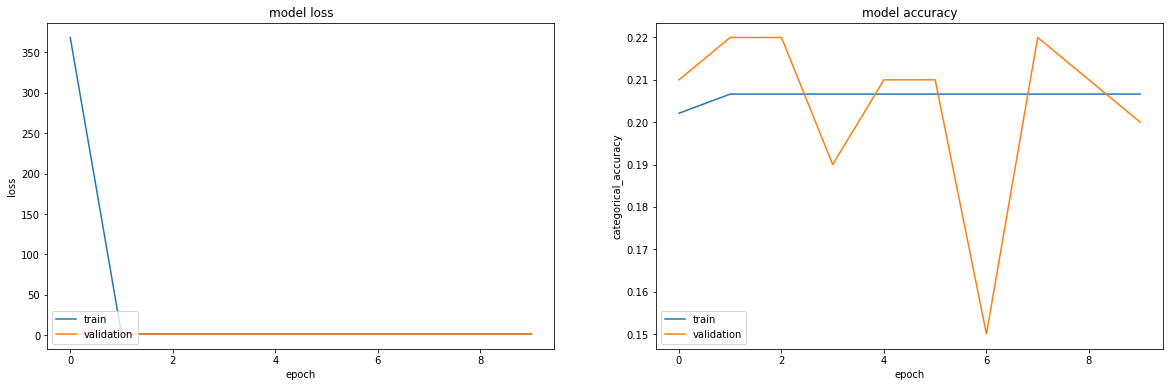

In [39]:
#Hyperparameters
batch_size = 32
num_epochs = 10

print ('# batch_size =', batch_size)
print ('# epochs =', num_epochs)

experiment_name = 'Conv3D'
experiment_number = 'Experiment_5'
img_x = 80
img_y = 80
img_idx = range(0,29)
input_shape = (len(img_idx),img_x,img_y,3)

#Data Generator
train_generator,val_generator = data_generator(img_idx,img_x,img_y,batch_size)

#Create the model
model = conv3d_1(input_shape,'Adam')
callbacks_list = define_checkpoint_callback()
steps_per_epoch, validation_steps = epoch_steps()

#Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
#Plot the results
modelplot(history)

## Experiment 6
<b>Conv3D: NO Dropouts</b> - 
Odd Images | Batch Size = 32 | Optimizer = SGD | Number of Epochs = 10

# batch_size = 32
# epochs = 10
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 13, 78, 78, 32)    2624      
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 6, 39, 39, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 4, 37, 37, 64)     55360     
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 2, 18, 18, 64)    0         
 g3D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 41472)             0         
                                                                 
 dense_12 (Dense)     

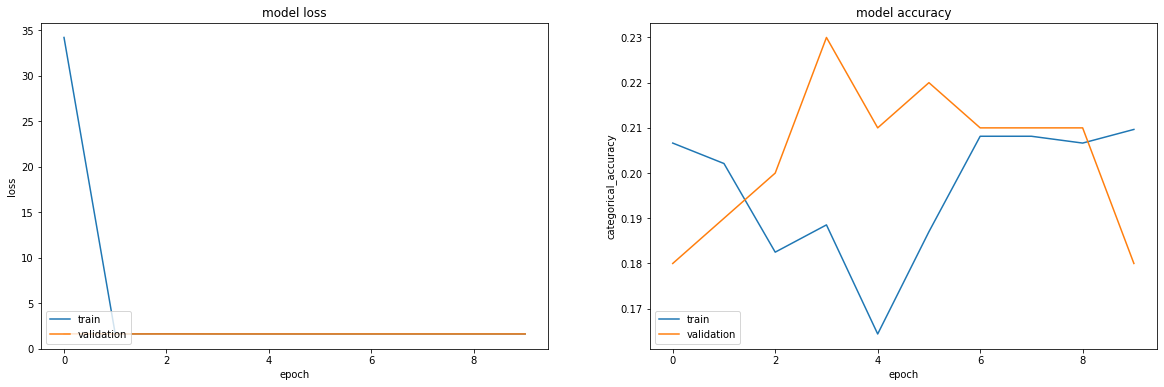

In [40]:
#Hyperparameters
batch_size = 32
num_epochs = 10

print ('# batch_size =', batch_size)
print ('# epochs =', num_epochs)

experiment_name = 'Conv3D'
experiment_number = 'Experiment_6'
img_x = 80
img_y = 80
img_idx = range(1, 30, 2)
input_shape = (len(img_idx),img_x,img_y,3)

#Data Generator
train_generator,val_generator = data_generator(img_idx,img_x,img_y,batch_size)

#Create the model
model = conv3d_1(input_shape,'SGD')
callbacks_list = define_checkpoint_callback()
steps_per_epoch, validation_steps = epoch_steps()

#Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
#Plot the results
modelplot(history)

## Experiment 7
<b>Conv3D: NO Dropouts</b> - 
Even Images | Batch Size = 32 | Optimizer = SGD | Number of Epochs = 10

# batch_size = 32
# epochs = 10
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_14 (Conv3D)          (None, 13, 78, 78, 32)    2624      
                                                                 
 max_pooling3d_14 (MaxPoolin  (None, 6, 39, 39, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_15 (Conv3D)          (None, 4, 37, 37, 64)     55360     
                                                                 
 max_pooling3d_15 (MaxPoolin  (None, 2, 18, 18, 64)    0         
 g3D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 41472)             0         
                                                                 
 dense_14 (Dense)     

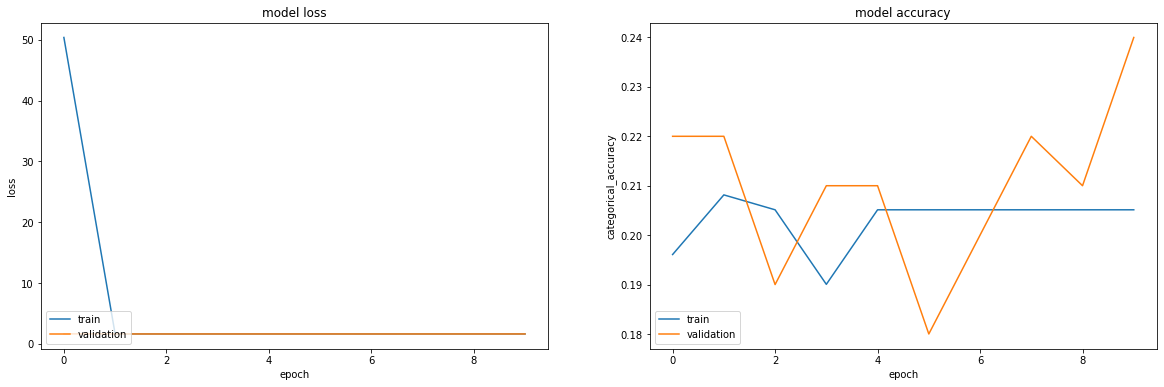

In [41]:
#Hyperparameters
batch_size = 32
num_epochs = 10

print ('# batch_size =', batch_size)
print ('# epochs =', num_epochs)

experiment_name = 'Conv3D'
experiment_number = 'Experiment_7'
img_x = 80
img_y = 80
img_idx = range(0, 29, 2)
input_shape = (len(img_idx),img_x,img_y,3)

#Data Generator
train_generator,val_generator = data_generator(img_idx,img_x,img_y,batch_size)

#Create the model
model = conv3d_1(input_shape,'SGD')
callbacks_list = define_checkpoint_callback()
steps_per_epoch, validation_steps = epoch_steps()

#Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
#Plot the results
modelplot(history)

## Experiment 8
<b>Conv3D: NO Dropouts</b> - 
Image indexes from 5-27 | Batch Size = 32 | Optimizer = SGD | Number of Epochs = 10

# batch_size = 32
# epochs = 10
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 20, 78, 78, 32)    2624      
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 10, 39, 39, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 8, 37, 37, 64)     55360     
                                                                 
 max_pooling3d_17 (MaxPoolin  (None, 4, 18, 18, 64)    0         
 g3D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 82944)             0         
                                                                 
 dense_16 (Dense)     

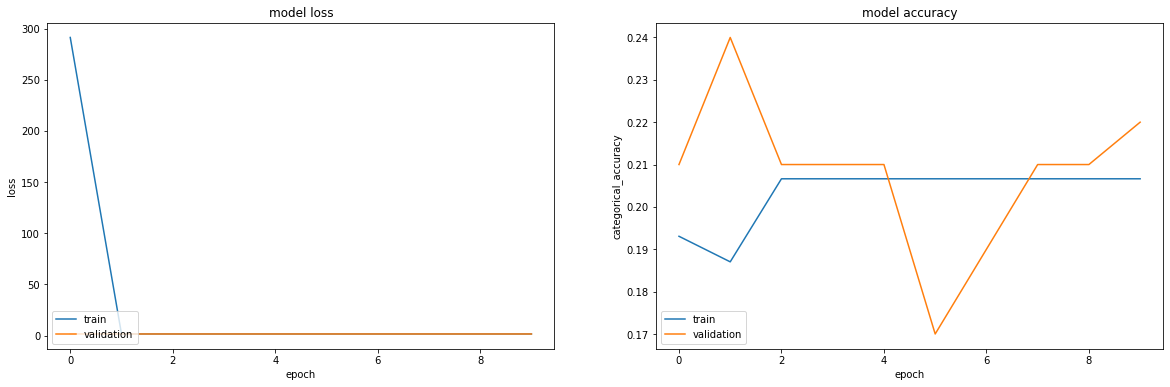

In [42]:
#Hyperparameters
batch_size = 32
num_epochs = 10

print ('# batch_size =', batch_size)
print ('# epochs =', num_epochs)

experiment_name = 'Conv3D'
experiment_number = 'Experiment_8'
img_x = 80
img_y = 80
img_idx = range(5, 27)
input_shape = (len(img_idx),img_x,img_y,3)

#Data Generator
train_generator,val_generator = data_generator(img_idx,img_x,img_y,batch_size)

#Create the model
model = conv3d_1(input_shape,'SGD')
callbacks_list = define_checkpoint_callback()
steps_per_epoch, validation_steps = epoch_steps()

#Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
#Plot the results
modelplot(history)

## Experiment 9
<b>Conv3D: NO Dropouts</b> - 
Image indexes from 5-27 | Batch Size = 32 | Optimizer = Adam | Number of Epochs = 10

# batch_size = 32
# epochs = 10
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_18 (Conv3D)          (None, 20, 78, 78, 32)    2624      
                                                                 
 max_pooling3d_18 (MaxPoolin  (None, 10, 39, 39, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_19 (Conv3D)          (None, 8, 37, 37, 64)     55360     
                                                                 
 max_pooling3d_19 (MaxPoolin  (None, 4, 18, 18, 64)    0         
 g3D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 82944)             0         
                                                                 
 dense_18 (Dense)     

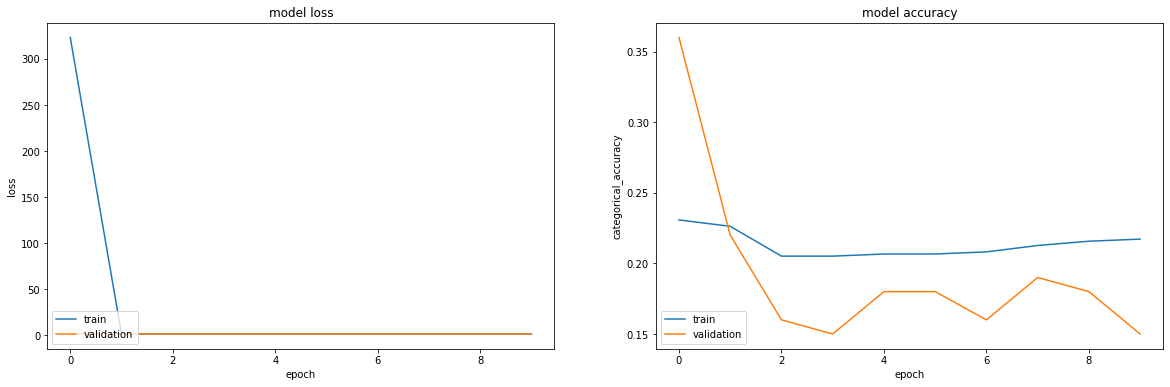

In [43]:
#Hyperparameters
batch_size = 32
num_epochs = 10

print ('# batch_size =', batch_size)
print ('# epochs =', num_epochs)

experiment_name = 'Conv3D'
experiment_number = 'Experiment_9'
img_x = 80
img_y = 80
img_idx = range(5, 27)
input_shape = (len(img_idx),img_x,img_y,3)

#Data Generator
train_generator,val_generator = data_generator(img_idx,img_x,img_y,batch_size)

#Create the model
model = conv3d_1(input_shape,'Adam')
callbacks_list = define_checkpoint_callback()
steps_per_epoch, validation_steps = epoch_steps()

#Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
#Plot the results
modelplot(history)

## Experiment 10
<b>Conv3D: With Dropouts</b> - 
All Images | Batch Size = 10 | Optimizer = SGD | Number of Epochs = 10

# batch_size = 10
# epochs = 10
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 29, 80, 80, 64)    5248      
                                                                 
 batch_normalization (BatchN  (None, 29, 80, 80, 64)   256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 29, 80, 80, 64)    0         
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 14, 40, 80, 64)   0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 14, 40, 80, 128)   221312    
                                                                 
 batch_normalization_

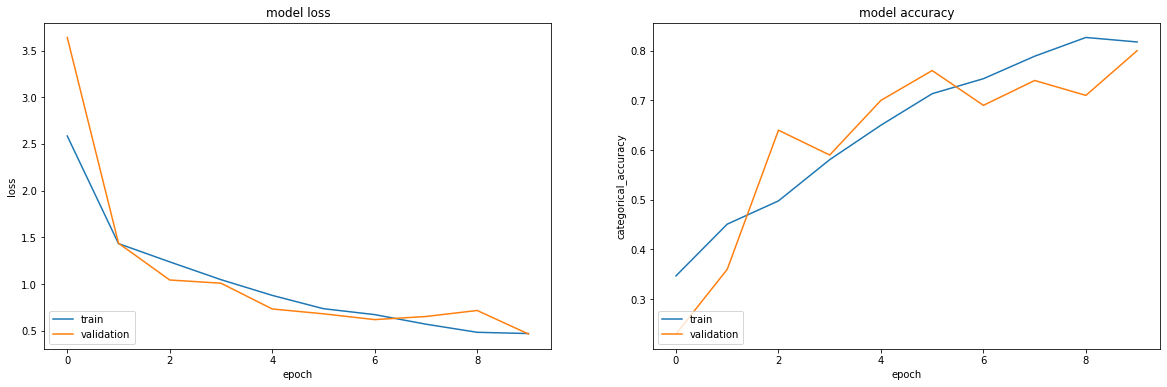

In [44]:
#Hyperparameters
batch_size = 10
num_epochs = 10

print ('# batch_size =', batch_size)
print ('# epochs =', num_epochs)

experiment_name = 'Conv3D'
experiment_number = 'Experiment_10'
img_x = 80
img_y = 80
img_idx = range(0, 29)
input_shape = (len(img_idx),img_x,img_y,3)

#Data Generator
train_generator,val_generator = data_generator(img_idx,img_x,img_y,batch_size)

#Create the model
model = conv3d_2(input_shape,'SGD', dropout=0.5)
callbacks_list = define_checkpoint_callback()
steps_per_epoch, validation_steps = epoch_steps()

#Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
#Plot the results
modelplot(history)

## Experiment 11
<b>Conv3D: With Dropouts</b> - 
All Images | Batch Size = 16 | Optimizer = SGD | Number of Epochs = 10

# batch_size = 16
# epochs = 10
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 29, 80, 80, 64)    5248      
                                                                 
 batch_normalization_4 (Batc  (None, 29, 80, 80, 64)   256       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 29, 80, 80, 64)    0         
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 14, 40, 80, 64)   0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 14, 40, 80, 128)   221312    
                                                                 
 batch_normalization_

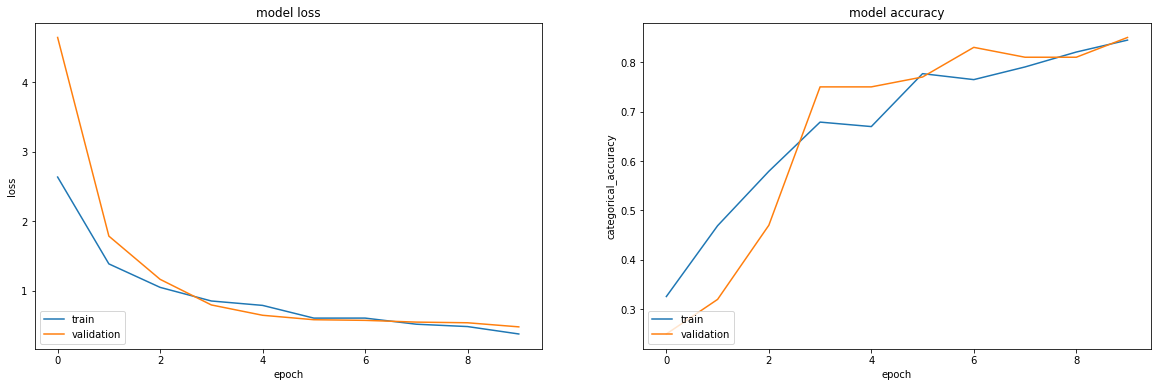

In [45]:
#Hyperparameters
batch_size = 16
num_epochs = 10

print ('# batch_size =', batch_size)
print ('# epochs =', num_epochs)

experiment_name = 'Conv3D'
experiment_number = 'Experiment_11'
img_x = 80
img_y = 80
img_idx = range(0, 29)
input_shape = (len(img_idx),img_x,img_y,3)

#Data Generator
train_generator,val_generator = data_generator(img_idx,img_x,img_y,batch_size)

#Create the model
model = conv3d_2(input_shape,'SGD', dropout=0.5)
callbacks_list = define_checkpoint_callback()
steps_per_epoch, validation_steps = epoch_steps()

#Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
#Plot the results
modelplot(history)

## Experiment 12
<b>Conv3D: With Dropouts</b> - 
All Images | Batch Size = 20 | Optimizer = SGD | Number of Epochs = 10

# batch_size = 20
# epochs = 10
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 29, 80, 80, 64)    5248      
                                                                 
 batch_normalization_8 (Batc  (None, 29, 80, 80, 64)   256       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 29, 80, 80, 64)    0         
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 14, 40, 80, 64)   0         
 g3D)                                                            
                                                                 
 conv3d_29 (Conv3D)          (None, 14, 40, 80, 128)   221312    
                                                                 
 batch_normalization_

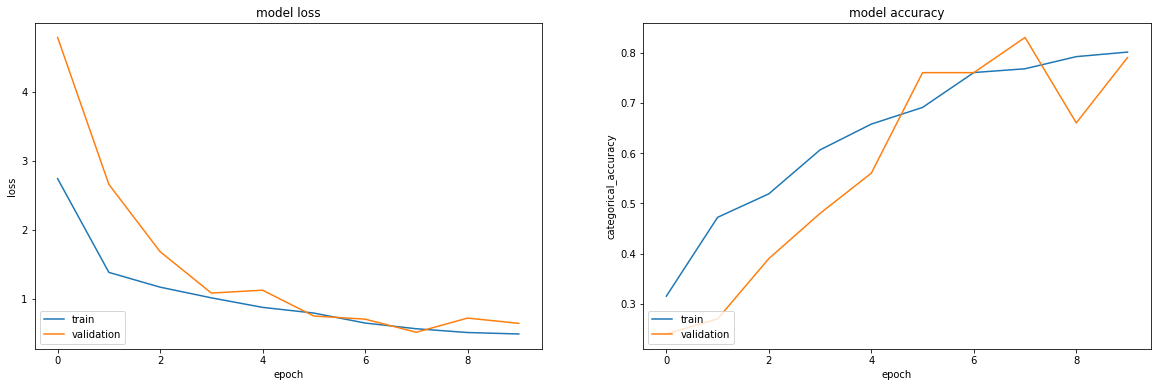

In [46]:
#Hyperparameters
batch_size = 20
num_epochs = 10

print ('# batch_size =', batch_size)
print ('# epochs =', num_epochs)

experiment_name = 'Conv3D'
experiment_number = 'Experiment_12'
img_x = 80
img_y = 80
img_idx = range(0, 29)
input_shape = (len(img_idx),img_x,img_y,3)

#Data Generator
train_generator,val_generator = data_generator(img_idx,img_x,img_y,batch_size)

#Create the model
model = conv3d_2(input_shape,'SGD', dropout=0.5)
callbacks_list = define_checkpoint_callback()
steps_per_epoch, validation_steps = epoch_steps()

#Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
#Plot the results
modelplot(history)

## Experiment 13
<b>Conv3D: With Dropouts</b> - 
All Images | Batch Size = 32 | Optimizer = SGD | Number of Epochs = 10

# batch_size = 32
# epochs = 10
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 29, 80, 80, 64)    5248      
                                                                 
 batch_normalization_12 (Bat  (None, 29, 80, 80, 64)   256       
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 29, 80, 80, 64)    0         
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 14, 40, 80, 64)   0         
 g3D)                                                            
                                                                 
 conv3d_33 (Conv3D)          (None, 14, 40, 80, 128)   221312    
                                                                 
 batch_normalization_

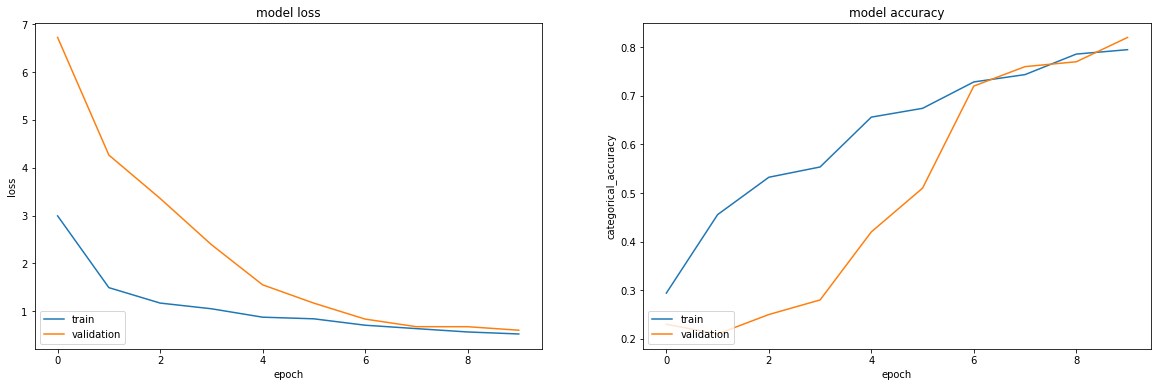

In [47]:
#Hyperparameters
batch_size = 32
num_epochs = 10

experiment_name = 'Conv3D'
experiment_number = 'Experiment_13'
print ('# batch_size =', batch_size)
print ('# epochs =', num_epochs)

img_x = 80
img_y = 80
img_idx = range(0, 29)
input_shape = (len(img_idx),img_x,img_y,3)

#Data Generator
train_generator,val_generator = data_generator(img_idx,img_x,img_y,batch_size)

#Create the model
model = conv3d_2(input_shape,'SGD', dropout=0.5)
callbacks_list = define_checkpoint_callback()
steps_per_epoch, validation_steps = epoch_steps()

#Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
#Plot the results
modelplot(history)

## Experiment 14
<b>Conv3D: With Dropouts</b> - 
All Images | Batch Size = 32 | Optimizer = Adam | Number of Epochs = 10

# batch_size = 32
# epochs = 10
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_36 (Conv3D)          (None, 29, 80, 80, 64)    5248      
                                                                 
 batch_normalization_16 (Bat  (None, 29, 80, 80, 64)   256       
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 29, 80, 80, 64)    0         
                                                                 
 max_pooling3d_36 (MaxPoolin  (None, 14, 40, 80, 64)   0         
 g3D)                                                            
                                                                 
 conv3d_37 (Conv3D)          (None, 14, 40, 80, 128)   221312    
                                                                 
 batch_normalization_

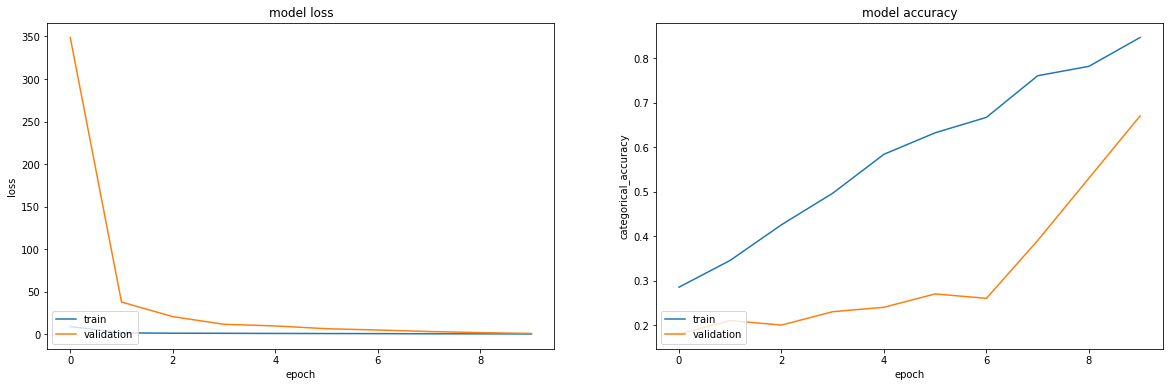

In [48]:
#Hyperparameters
batch_size = 32
num_epochs = 10

print ('# batch_size =', batch_size)
print ('# epochs =', num_epochs)

experiment_name = 'Conv3D'
experiment_number = 'Experiment_14'
img_x = 80
img_y = 80
img_idx = range(0, 29)
input_shape = (len(img_idx),img_x,img_y,3)

#Data Generator
train_generator,val_generator = data_generator(img_idx,img_x,img_y,batch_size)

#Create the model
model = conv3d_2(input_shape,'Adam', dropout=0.5)
callbacks_list = define_checkpoint_callback()
steps_per_epoch, validation_steps = epoch_steps()

#Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
#Plot the results
modelplot(history)

## Experiment 15
<b>Conv3D: With Dropouts = 0.25</b> - 
Image indexes from 5-27 | Batch Size = 32 | Optimizer = SGD | Number of Epochs = 10

# batch_size = 32
# epochs = 10
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_40 (Conv3D)          (None, 22, 80, 80, 64)    5248      
                                                                 
 batch_normalization_20 (Bat  (None, 22, 80, 80, 64)   256       
 chNormalization)                                                
                                                                 
 activation_20 (Activation)  (None, 22, 80, 80, 64)    0         
                                                                 
 max_pooling3d_40 (MaxPoolin  (None, 11, 40, 80, 64)   0         
 g3D)                                                            
                                                                 
 conv3d_41 (Conv3D)          (None, 11, 40, 80, 128)   221312    
                                                                 
 batch_normalization_

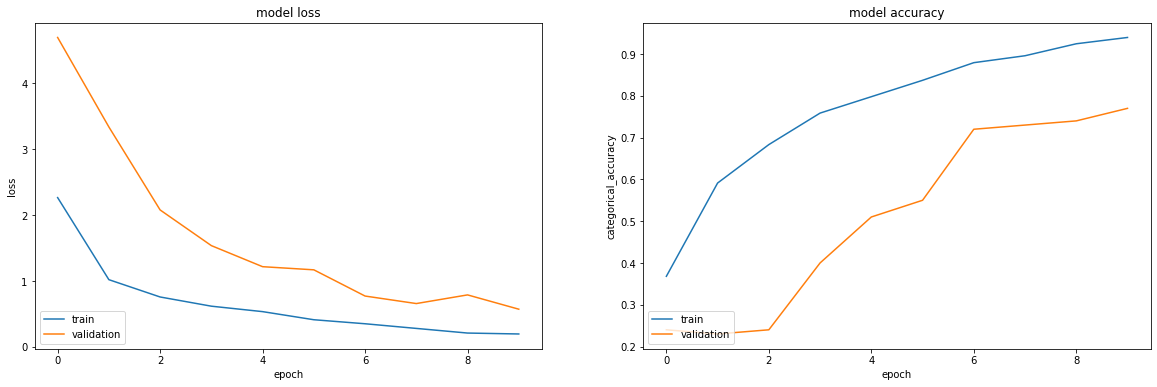

In [49]:
#Hyperparameters
batch_size = 32
num_epochs = 10

print ('# batch_size =', batch_size)
print ('# epochs =', num_epochs)

experiment_name = 'Conv3D'
experiment_number = 'Experiment_15'
img_x = 80
img_y = 80
img_idx = range(5, 27)
input_shape = (len(img_idx),img_x,img_y,3)

#Data Generator
train_generator,val_generator = data_generator(img_idx,img_x,img_y,batch_size)

#Create the model
model = conv3d_2(input_shape,'SGD', dropout=0.25)
callbacks_list = define_checkpoint_callback()
steps_per_epoch, validation_steps = epoch_steps()

#Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
#Plot the results
modelplot(history)

## Experiment 16
<b>Conv3D: With Dropouts = 0.5</b> - 
Image indexes from 5-27 | Batch Size = 32 | Optimizer = SGD | Number of Epochs = 10

# batch_size = 32
# epochs = 10
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_44 (Conv3D)          (None, 22, 80, 80, 64)    5248      
                                                                 
 batch_normalization_24 (Bat  (None, 22, 80, 80, 64)   256       
 chNormalization)                                                
                                                                 
 activation_24 (Activation)  (None, 22, 80, 80, 64)    0         
                                                                 
 max_pooling3d_44 (MaxPoolin  (None, 11, 40, 80, 64)   0         
 g3D)                                                            
                                                                 
 conv3d_45 (Conv3D)          (None, 11, 40, 80, 128)   221312    
                                                                 
 batch_normalization_

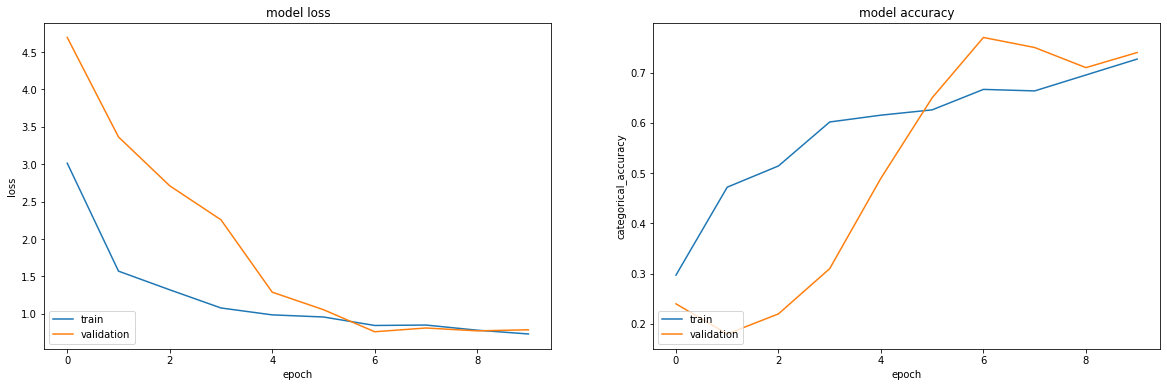

In [50]:
#Hyperparameters
batch_size = 32
num_epochs = 10

print ('# batch_size =', batch_size)
print ('# epochs =', num_epochs)

experiment_name = 'Conv3D'
experiment_number = 'Experiment_16'
img_x = 80
img_y = 80
img_idx = range(5, 27)
input_shape = (len(img_idx),img_x,img_y,3)

#Data Generator
train_generator,val_generator = data_generator(img_idx,img_x,img_y,batch_size)

#Create the model
model = conv3d_2(input_shape,'SGD', dropout=0.5)
callbacks_list = define_checkpoint_callback()
steps_per_epoch, validation_steps = epoch_steps()

#Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
#Plot the results
modelplot(history)

## Experiment 17
<b>Conv3D: With Dropouts</b> - 
Image indexes from 5-27 | Batch Size = 32 | Optimizer = Adam | Number of Epochs = 10

# batch_size = 32
# epochs = 10
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_48 (Conv3D)          (None, 22, 80, 80, 64)    5248      
                                                                 
 batch_normalization_28 (Bat  (None, 22, 80, 80, 64)   256       
 chNormalization)                                                
                                                                 
 activation_28 (Activation)  (None, 22, 80, 80, 64)    0         
                                                                 
 max_pooling3d_48 (MaxPoolin  (None, 11, 40, 80, 64)   0         
 g3D)                                                            
                                                                 
 conv3d_49 (Conv3D)          (None, 11, 40, 80, 128)   221312    
                                                                 
 batch_normalization_

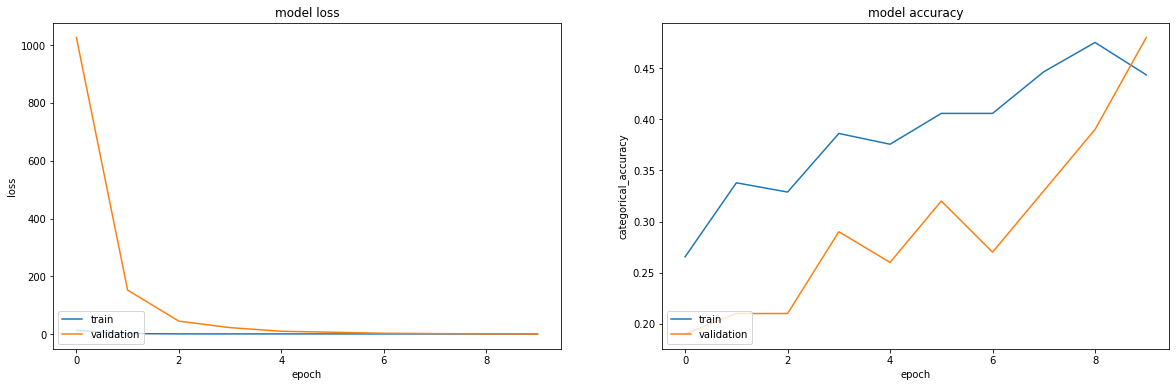

In [51]:
#Hyperparameters
batch_size = 32
num_epochs = 10

print ('# batch_size =', batch_size)
print ('# epochs =', num_epochs)

experiment_name = 'Conv3D'
experiment_number = 'Experiment_17'
img_x = 80
img_y = 80
img_idx = range(5, 27)
input_shape = (len(img_idx),img_x,img_y,3)

#Data Generator
train_generator,val_generator = data_generator(img_idx,img_x,img_y,batch_size)

#Create the model
model = conv3d_2(input_shape,'Adam', dropout=0.5)
callbacks_list = define_checkpoint_callback()
steps_per_epoch, validation_steps = epoch_steps()

#Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
#Plot the results
modelplot(history)

## Experiment 18
<b>Conv2D + LSTM</b> - 
All Images | Batch Size = 10 | Optimizer = SGD | Number of Epochs = 10

# batch_size = 10
# epochs = 10


2023-06-17 05:42:00.537809: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-06-17 05:42:00.537901: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 29, 78, 78, 8)    224       
 ibuted)                                                         
                                                                 
 batch_normalization (BatchN  (None, 29, 78, 78, 8)    32        
 ormalization)                                                   
                                                                 
 time_distributed_1 (TimeDis  (None, 29, 76, 76, 16)   1168      
 tributed)                                                       
                                                                 
 batch_normalization_1 (Batc  (None, 29, 76, 76, 16)   64        
 hNormalization)                                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 74, 74, 8)         6

2023-06-17 05:42:04.260311: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


67/67 [==============================] - ETA: 0s - loss: 1.6261 - categorical_accuracy: 0.1885
Epoch 00001: saving model to model_Conv2D_LSTM_2023-06-1705_41_32.842698/Experiment_18-00001-1.62611-0.18854-1.60804-0.22000.h5
67/67 [==============================] - 43s 585ms/step - loss: 1.6261 - categorical_accuracy: 0.1885 - val_loss: 1.6080 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 1.5498 - categorical_accuracy: 0.2760
Epoch 00002: saving model to model_Conv2D_LSTM_2023-06-1705_41_32.842698/Experiment_18-00002-1.54978-0.27602-1.58045-0.35000.h5
67/67 [==============================] - 38s 577ms/step - loss: 1.5498 - categorical_accuracy: 0.2760 - val_loss: 1.5804 - val_categorical_accuracy: 0.3500 - lr: 0.0010
Epoch 3/10
67/67 [==============================] - ETA: 0s - loss: 1.4952 - categorical_accuracy: 0.3665
Epoch 00003: saving model to model_Conv2D_LSTM_2023-06-1705_41_32.842698/Experiment_18-00003-1.4951

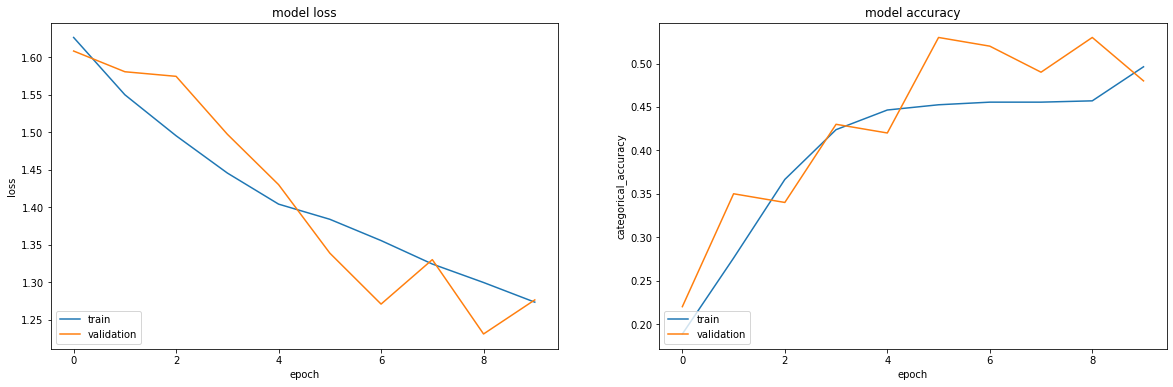

In [17]:
#Hyperparameters
batch_size = 10
num_epochs = 10

print ('# batch_size =', batch_size)
print ('# epochs =', num_epochs)

experiment_name = 'Conv2D_LSTM'
experiment_number = 'Experiment_18'
img_x = 80
img_y = 80
img_idx = range(0, 29)
input_shape = (len(img_idx),img_x,img_y,3)

#Data Generator
train_generator,val_generator = data_generator(img_idx,img_x,img_y,batch_size)

#Create the model
model = conv2d_lstm_1(input_shape, 'SGD')
callbacks_list = define_checkpoint_callback()
steps_per_epoch, validation_steps = epoch_steps()

#Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
#Plot the results
modelplot(history)

## Experiment 19
<b>Conv2D + LSTM</b> - 
All Images | Batch Size = 16 | Optimizer = SGD | Number of Epochs = 10

# batch_size = 16
# epochs = 10
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 29, 78, 78, 8)    224       
 tributed)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 29, 78, 78, 8)    32        
 hNormalization)                                                 
                                                                 
 time_distributed_4 (TimeDis  (None, 29, 76, 76, 16)   1168      
 tributed)                                                       
                                                                 
 batch_normalization_5 (Batc  (None, 29, 76, 76, 16)   64        
 hNormalization)                                                 
                                                                 
 conv_lstm2d_1 (ConvLS

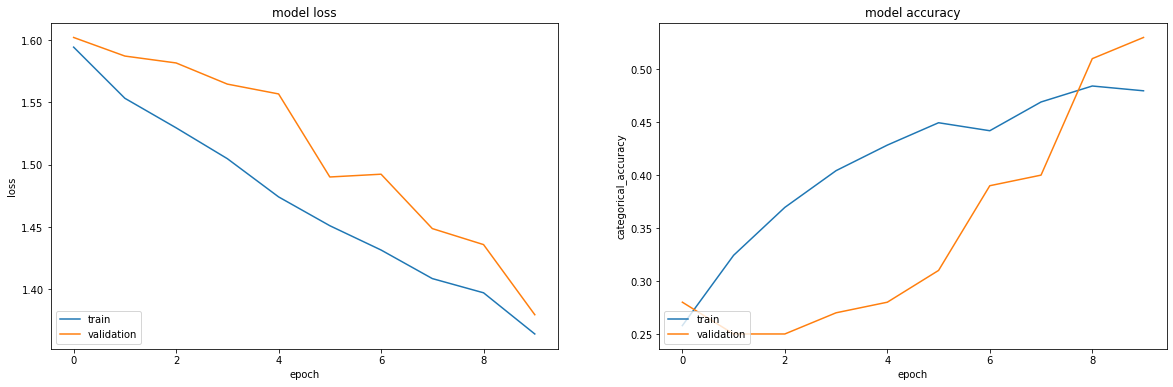

In [18]:
#Hyperparameters
batch_size = 16
num_epochs = 10

print ('# batch_size =', batch_size)
print ('# epochs =', num_epochs)

experiment_name = 'Conv2D_LSTM'
experiment_number = 'Experiment_19'
img_x = 80
img_y = 80
img_idx = range(0, 29)
input_shape = (len(img_idx),img_x,img_y,3)

#Data Generator
train_generator,val_generator = data_generator(img_idx,img_x,img_y,batch_size)

#Create the model
model = conv2d_lstm_1(input_shape, 'SGD')
callbacks_list = define_checkpoint_callback()
steps_per_epoch, validation_steps = epoch_steps()

#Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
#Plot the results
modelplot(history)

## Experiment 20
<b>Conv2D + LSTM</b> - 
All Images | Batch Size = 20 | Optimizer = SGD | Number of Epochs = 10

# batch_size = 20
# epochs = 10
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 29, 78, 78, 8)    224       
 tributed)                                                       
                                                                 
 batch_normalization_8 (Batc  (None, 29, 78, 78, 8)    32        
 hNormalization)                                                 
                                                                 
 time_distributed_7 (TimeDis  (None, 29, 76, 76, 16)   1168      
 tributed)                                                       
                                                                 
 batch_normalization_9 (Batc  (None, 29, 76, 76, 16)   64        
 hNormalization)                                                 
                                                                 
 conv_lstm2d_2 (ConvLS

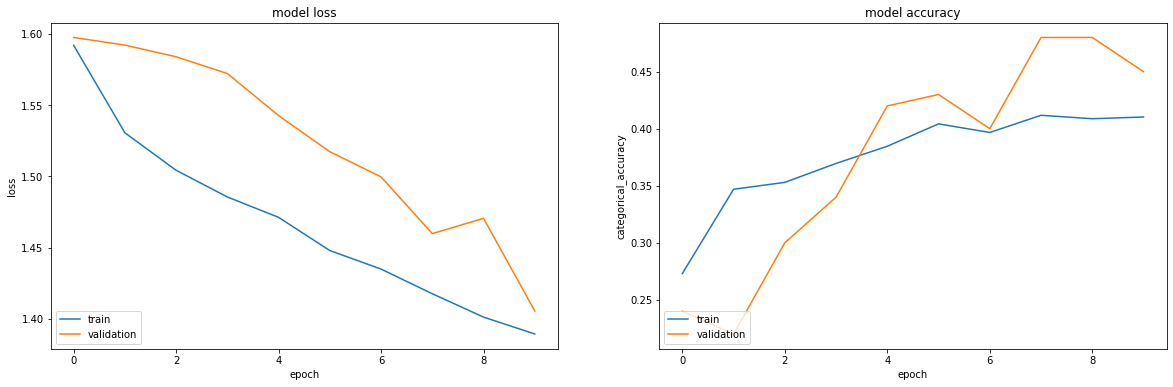

In [19]:
#Hyperparameters
batch_size = 20
num_epochs = 10

experiment_name = 'Conv2D_LSTM'
experiment_number = 'Experiment_20'
print ('# batch_size =', batch_size)
print ('# epochs =', num_epochs)

img_x = 80
img_y = 80
img_idx = range(0, 29)
input_shape = (len(img_idx),img_x,img_y,3)

#Data Generator
train_generator,val_generator = data_generator(img_idx,img_x,img_y,batch_size)

#Create the model
model = conv2d_lstm_1(input_shape, 'SGD')
callbacks_list = define_checkpoint_callback()
steps_per_epoch, validation_steps = epoch_steps()

#Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
#Plot the results
modelplot(history)

## Experiment 21
<b>Conv2D + LSTM</b> - 
All Images | Batch Size = 32 | Optimizer = SGD | Number of Epochs = 10

# batch_size = 32
# epochs = 10
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDis  (None, 29, 78, 78, 8)    224       
 tributed)                                                       
                                                                 
 batch_normalization_12 (Bat  (None, 29, 78, 78, 8)    32        
 chNormalization)                                                
                                                                 
 time_distributed_10 (TimeDi  (None, 29, 76, 76, 16)   1168      
 stributed)                                                      
                                                                 
 batch_normalization_13 (Bat  (None, 29, 76, 76, 16)   64        
 chNormalization)                                                
                                                                 
 conv_lstm2d_3 (ConvLS

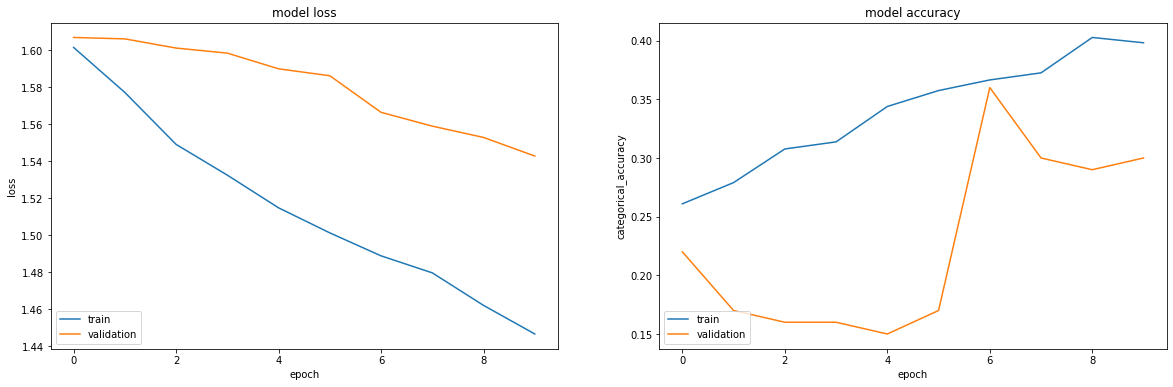

In [20]:
#Hyperparameters
batch_size = 32
num_epochs = 10

print ('# batch_size =', batch_size)
print ('# epochs =', num_epochs)

experiment_name = 'Conv2D_LSTM'
experiment_number = 'Experiment_21'
img_x = 80
img_y = 80
img_idx = range(0, 29)
input_shape = (len(img_idx),img_x,img_y,3)

#Data Generator
train_generator,val_generator = data_generator(img_idx,img_x,img_y,batch_size)

#Create the model
model = conv2d_lstm_1(input_shape, 'SGD')
callbacks_list = define_checkpoint_callback()
steps_per_epoch, validation_steps = epoch_steps()

#Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
#Plot the results
modelplot(history)

## Experiment 22
<b>Conv2D + LSTM</b> - 
All Images | Batch Size = 32 | Optimizer = Adam | Number of Epochs = 10

# batch_size = 32
# epochs = 10
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 29, 78, 78, 8)    224       
 stributed)                                                      
                                                                 
 batch_normalization_16 (Bat  (None, 29, 78, 78, 8)    32        
 chNormalization)                                                
                                                                 
 time_distributed_13 (TimeDi  (None, 29, 76, 76, 16)   1168      
 stributed)                                                      
                                                                 
 batch_normalization_17 (Bat  (None, 29, 76, 76, 16)   64        
 chNormalization)                                                
                                                                 
 conv_lstm2d_4 (ConvLS

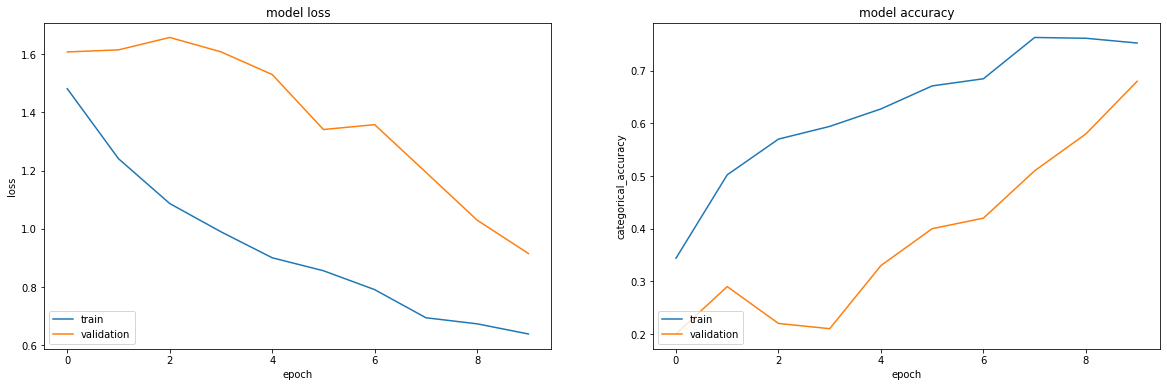

In [21]:
#Hyperparameters
batch_size = 32
num_epochs = 10

print ('# batch_size =', batch_size)
print ('# epochs =', num_epochs)

experiment_name = 'Conv2D_LSTM'
experiment_number = 'Experiment_22'
img_x = 80
img_y = 80
img_idx = range(0, 29)
input_shape = (len(img_idx),img_x,img_y,3)

#Data Generator
train_generator,val_generator = data_generator(img_idx,img_x,img_y,batch_size)

#Create the model
model = conv2d_lstm_1(input_shape, 'Adam')
callbacks_list = define_checkpoint_callback()
steps_per_epoch, validation_steps = epoch_steps()

#Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
#Plot the results
modelplot(history)

## Experiment 23
<b>Conv2D + LSTM</b> - 
Odd Images | Batch Size = 32 | Optimizer = SGD | Number of Epochs = 10

# batch_size = 32
# epochs = 10
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_15 (TimeDi  (None, 15, 78, 78, 8)    224       
 stributed)                                                      
                                                                 
 batch_normalization_20 (Bat  (None, 15, 78, 78, 8)    32        
 chNormalization)                                                
                                                                 
 time_distributed_16 (TimeDi  (None, 15, 76, 76, 16)   1168      
 stributed)                                                      
                                                                 
 batch_normalization_21 (Bat  (None, 15, 76, 76, 16)   64        
 chNormalization)                                                
                                                                 
 conv_lstm2d_5 (ConvLS

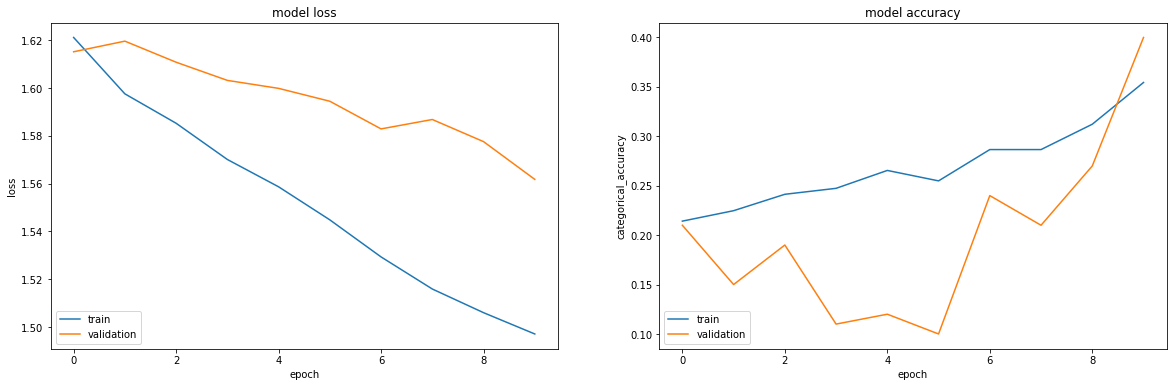

In [22]:
#Hyperparameters
batch_size = 32
num_epochs = 10

print ('# batch_size =', batch_size)
print ('# epochs =', num_epochs)

experiment_name = 'Conv2D_LSTM'
experiment_number = 'Experiment_23'
img_x = 80
img_y = 80
img_idx = range(1, 30, 2)
input_shape = (len(img_idx),img_x,img_y,3)

#Data Generator
train_generator,val_generator = data_generator(img_idx,img_x,img_y,batch_size)

#Create the model
model = conv2d_lstm_1(input_shape, 'SGD')
callbacks_list = define_checkpoint_callback()
steps_per_epoch, validation_steps = epoch_steps()

#Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
#Plot the results
modelplot(history)

## Experiment 24
<b>Conv2D + LSTM</b> - 
Even Images | Batch Size = 32 | Optimizer = SGD | Number of Epochs = 10

# batch_size = 32
# epochs = 10
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_18 (TimeDi  (None, 15, 78, 78, 8)    224       
 stributed)                                                      
                                                                 
 batch_normalization_24 (Bat  (None, 15, 78, 78, 8)    32        
 chNormalization)                                                
                                                                 
 time_distributed_19 (TimeDi  (None, 15, 76, 76, 16)   1168      
 stributed)                                                      
                                                                 
 batch_normalization_25 (Bat  (None, 15, 76, 76, 16)   64        
 chNormalization)                                                
                                                                 
 conv_lstm2d_6 (ConvLS

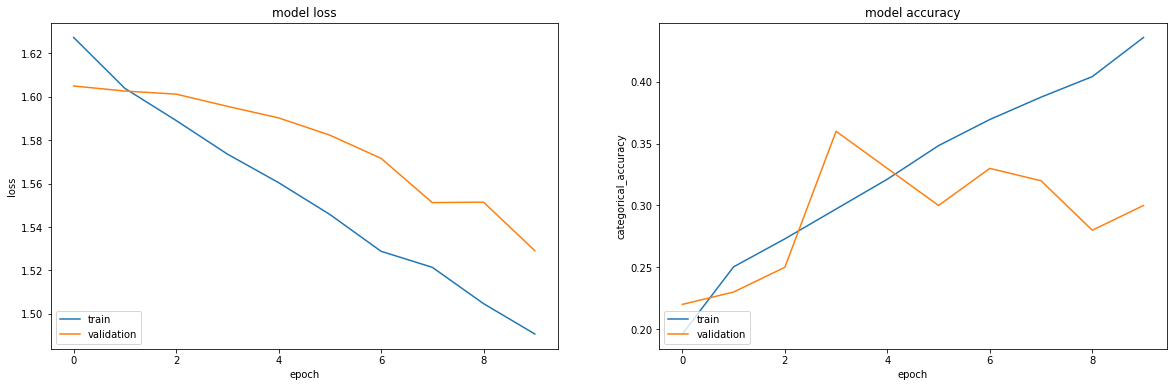

In [23]:
#Hyperparameters
batch_size = 32
num_epochs = 10

print ('# batch_size =', batch_size)
print ('# epochs =', num_epochs)

experiment_name = 'Conv2D_LSTM'
experiment_number = 'Experiment_24'
img_x = 80
img_y = 80
img_idx = range(0, 29, 2)
input_shape = (len(img_idx),img_x,img_y,3)

#Data Generator
train_generator,val_generator = data_generator(img_idx,img_x,img_y,batch_size)

#Create the model
model = conv2d_lstm_1(input_shape, 'SGD')
callbacks_list = define_checkpoint_callback()
steps_per_epoch, validation_steps = epoch_steps()

#Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
#Plot the results
modelplot(history)

## Experiment 25
<b>Conv2D + LSTM</b> - 
Image indexes from 5-27 | Batch Size = 32 | Optimizer = SGD | Number of Epochs = 10

# batch_size = 32
# epochs = 10
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_21 (TimeDi  (None, 22, 78, 78, 8)    224       
 stributed)                                                      
                                                                 
 batch_normalization_28 (Bat  (None, 22, 78, 78, 8)    32        
 chNormalization)                                                
                                                                 
 time_distributed_22 (TimeDi  (None, 22, 76, 76, 16)   1168      
 stributed)                                                      
                                                                 
 batch_normalization_29 (Bat  (None, 22, 76, 76, 16)   64        
 chNormalization)                                                
                                                                 
 conv_lstm2d_7 (ConvLS

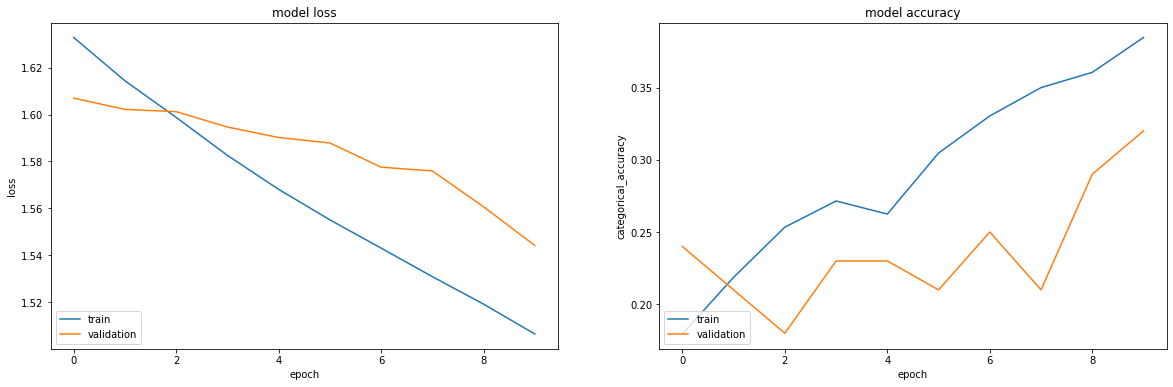

In [24]:
#Hyperparameters
batch_size = 32
num_epochs = 10

print ('# batch_size =', batch_size)
print ('# epochs =', num_epochs)

experiment_name = 'Conv2D_LSTM'
experiment_number = 'Experiment_25'
img_x = 80
img_y = 80
img_idx = range(5, 27)
input_shape = (len(img_idx),img_x,img_y,3)

#Data Generator
train_generator,val_generator = data_generator(img_idx,img_x,img_y,batch_size)

#Create the model
model = conv2d_lstm_1(input_shape, 'SGD')
callbacks_list = define_checkpoint_callback()
steps_per_epoch, validation_steps = epoch_steps()

#Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
#Plot the results
modelplot(history)

## Experiment 26
<b>Conv2D + LSTM</b> - 
Image indexes from 5-27 | Batch Size = 32 | Optimizer = Adam | Number of Epochs = 10

# batch_size = 32
# epochs = 10
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_24 (TimeDi  (None, 22, 78, 78, 8)    224       
 stributed)                                                      
                                                                 
 batch_normalization_32 (Bat  (None, 22, 78, 78, 8)    32        
 chNormalization)                                                
                                                                 
 time_distributed_25 (TimeDi  (None, 22, 76, 76, 16)   1168      
 stributed)                                                      
                                                                 
 batch_normalization_33 (Bat  (None, 22, 76, 76, 16)   64        
 chNormalization)                                                
                                                                 
 conv_lstm2d_8 (ConvLS

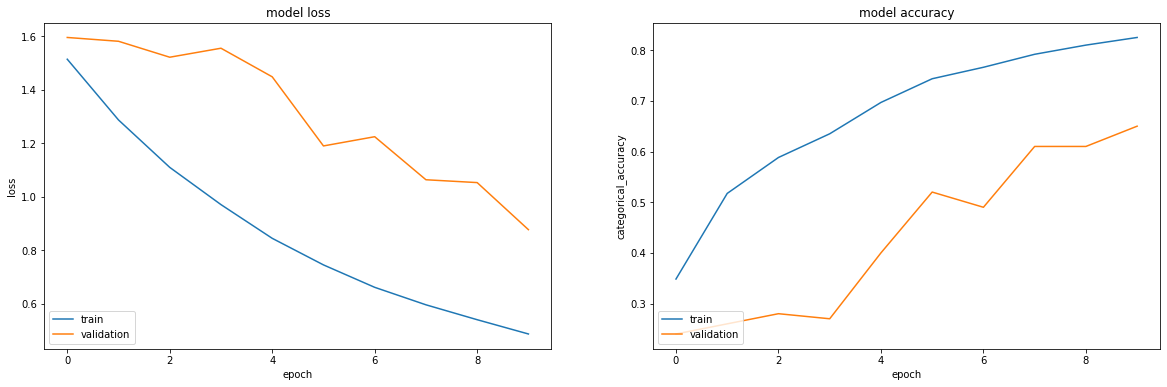

In [25]:
#Hyperparameters
batch_size = 32
num_epochs = 10

print ('# batch_size =', batch_size)
print ('# epochs =', num_epochs)

experiment_name = 'Conv2D_LSTM'
experiment_number = 'Experiment_26'
img_x = 80
img_y = 80
img_idx = range(5, 27)
input_shape = (len(img_idx),img_x,img_y,3)

#Data Generator
train_generator,val_generator = data_generator(img_idx,img_x,img_y,batch_size)

#Create the model
model = conv2d_lstm_1(input_shape, 'Adam')
callbacks_list = define_checkpoint_callback()
steps_per_epoch, validation_steps = epoch_steps()

#Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
#Plot the results
modelplot(history)

## Experiment 27
<b>Conv2D + GRU</b> - 
Image indexes from 5-27 | Batch Size = 32 | Optimizer = SGD | Number of Epochs = 10

# batch_size = 32
# epochs = 10
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_27 (TimeDi  (None, 22, 78, 78, 32)   896       
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 22, 39, 39, 32)   0         
 stributed)                                                      
                                                                 
 batch_normalization_36 (Bat  (None, 22, 39, 39, 32)   128       
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 22, 39, 39, 32)    0         
                                                                 
 time_distributed_29 (TimeDi  (None, 22, 37, 37, 64)   18496     
 stributed)           

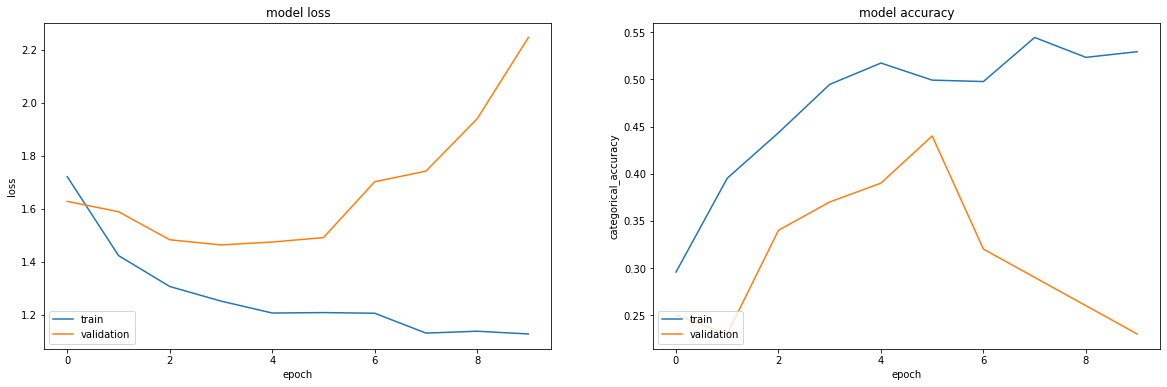

In [26]:
#Hyperparameters
batch_size = 32
num_epochs = 10

print ('# batch_size =', batch_size)
print ('# epochs =', num_epochs)

experiment_name = 'Conv2D_GRU'
experiment_number = 'Experiment_27'
img_x = 80
img_y = 80
img_idx = range(5, 27)
input_shape = (len(img_idx),img_x,img_y,3)

#Data Generator
train_generator,val_generator = data_generator(img_idx,img_x,img_y,batch_size)

#Create the model
model = conv2d_gru_1(input_shape, 'SGD', dropout=0.5)
callbacks_list = define_checkpoint_callback()
steps_per_epoch, validation_steps = epoch_steps()

#Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
#Plot the results
modelplot(history)

## Experiment 28
<b>Conv2D + Dense</b> - 
Image indexes from 5-27 | Batch Size = 32 | Optimizer = SGD | Number of Epochs = 10

# batch_size = 32
# epochs = 10
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_33 (TimeDi  (None, 22, 78, 78, 32)   896       
 stributed)                                                      
                                                                 
 time_distributed_34 (TimeDi  (None, 22, 39, 39, 32)   0         
 stributed)                                                      
                                                                 
 batch_normalization_40 (Bat  (None, 22, 39, 39, 32)   128       
 chNormalization)                                                
                                                                 
 time_distributed_35 (TimeDi  (None, 22, 37, 37, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_36 

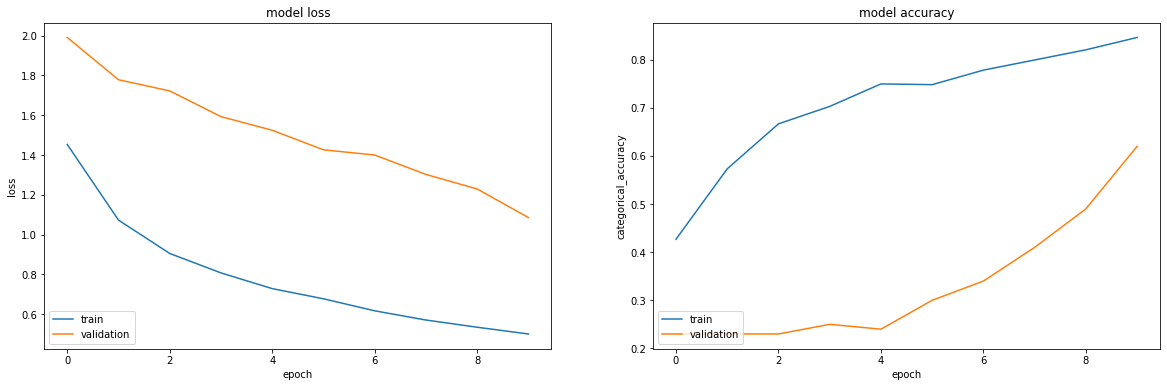

In [27]:
#Hyperparameters
batch_size = 32
num_epochs = 10

print ('# batch_size =', batch_size)
print ('# epochs =', num_epochs)

experiment_name = 'Conv2D_Dense'
experiment_number = 'Experiment_28'
img_x = 80
img_y = 80
img_idx = range(5, 27)
input_shape = (len(img_idx),img_x,img_y,3)

#Data Generator
train_generator,val_generator = data_generator(img_idx,img_x,img_y,batch_size)

#Create the model
model = conv2d_dense_1(input_shape, 'SGD', dropout=0.5)
callbacks_list = define_checkpoint_callback()
steps_per_epoch, validation_steps = epoch_steps()

#Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
#Plot the results
modelplot(history)

## Experiment 29
<b>Conv3D: With Dropouts = 0.25</b> - 
All Images | Batch Size = 20 | Optimizer = SGD | Number of Epochs = 10

# batch_size = 20
# epochs = 10
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 29, 80, 80, 64)    5248      
                                                                 
 batch_normalization_44 (Bat  (None, 29, 80, 80, 64)   256       
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 29, 80, 80, 64)    0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 14, 40, 80, 64)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 14, 40, 80, 128)   221312    
                                                                 
 batch_normalization_

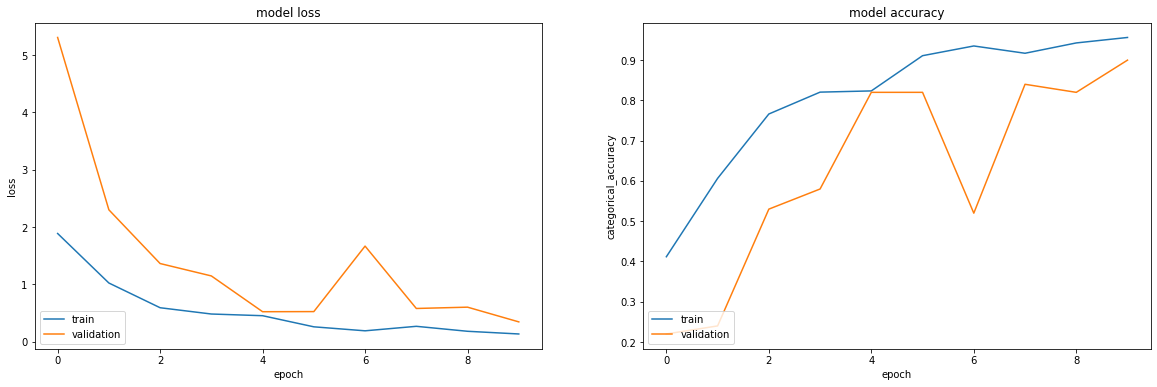

In [28]:
#Hyperparameters
batch_size = 20
num_epochs = 10

print ('# batch_size =', batch_size)
print ('# epochs =', num_epochs)

experiment_name = 'Conv3D'
experiment_number = 'Experiment_29'
img_x = 80
img_y = 80
img_idx = range(0, 29)
input_shape = (len(img_idx),img_x,img_y,3)

#Data Generator
train_generator,val_generator = data_generator(img_idx,img_x,img_y,batch_size)

#Create the model
model = conv3d_2(input_shape,'SGD', dropout=0.25)
callbacks_list = define_checkpoint_callback()
steps_per_epoch, validation_steps = epoch_steps()

#Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
#Plot the results
modelplot(history)

## Experiment 30
<b>Conv3D: With Dropouts = 0.25</b> - 
All Images | Batch Size = 20 | Optimizer = Adam | Number of Epochs = 10

# batch_size = 20
# epochs = 10
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 29, 80, 80, 64)    5248      
                                                                 
 batch_normalization_48 (Bat  (None, 29, 80, 80, 64)   256       
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 29, 80, 80, 64)    0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 14, 40, 80, 64)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 14, 40, 80, 128)   221312    
                                                                 
 batch_normalization_

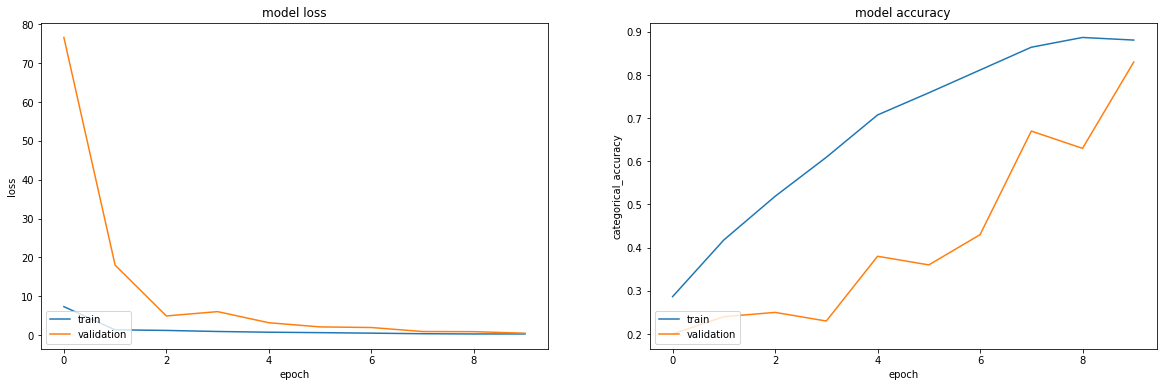

In [29]:
#Hyperparameters
batch_size = 20
num_epochs = 10

print ('# batch_size =', batch_size)
print ('# epochs =', num_epochs)

experiment_name = 'Conv3D'
experiment_number = 'Experiment_30'
img_x = 80
img_y = 80
img_idx = range(0, 29)
input_shape = (len(img_idx),img_x,img_y,3)

#Data Generator
train_generator,val_generator = data_generator(img_idx,img_x,img_y,batch_size)

#Create the model
model = conv3d_2(input_shape,'Adam', dropout=0.25)
callbacks_list = define_checkpoint_callback()
steps_per_epoch, validation_steps = epoch_steps()

#Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
#Plot the results
modelplot(history)

## Experiment 31
<b>Conv2d + LSTM2D: </b> - 
All Images | Batch Size = 32 | Optimizer = SGD | Number of Epochs = 50

# batch_size = 32
# epochs = 50


2023-06-17 09:45:03.912522: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-06-17 09:45:03.912587: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 29, 78, 78, 8)    224       
 ibuted)                                                         
                                                                 
 batch_normalization (BatchN  (None, 29, 78, 78, 8)    32        
 ormalization)                                                   
                                                                 
 time_distributed_1 (TimeDis  (None, 29, 76, 76, 16)   1168      
 tributed)                                                       
                                                                 
 batch_normalization_1 (Batc  (None, 29, 76, 76, 16)   64        
 hNormalization)                                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 74, 74, 8)         6

2023-06-17 09:45:09.205642: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 1.6188 - categorical_accuracy: 0.2278
Epoch 00001: saving model to model_Conv2D_LSTM2D_2023-06-1709_44_43.262552/Experiment_31-00001-1.61877-0.22775-1.59891-0.25000.h5
21/21 [==============================] - 47s 2s/step - loss: 1.6188 - categorical_accuracy: 0.2278 - val_loss: 1.5989 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.5808 - categorical_accuracy: 0.2579
Epoch 00002: saving model to model_Conv2D_LSTM2D_2023-06-1709_44_43.262552/Experiment_31-00002-1.58080-0.25792-1.59654-0.22000.h5
21/21 [==============================] - 43s 2s/step - loss: 1.5808 - categorical_accuracy: 0.2579 - val_loss: 1.5965 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 1.5607 - categorical_accuracy: 0.3047
Epoch 00003: saving model to model_Conv2D_LSTM2D_2023-06-1709_44_43.262552/Experiment_31-00003-1.5607

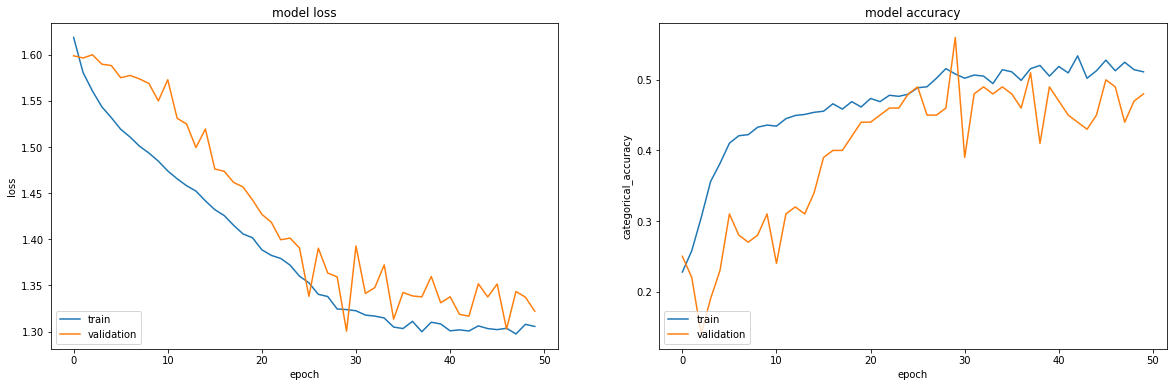

In [18]:

#Hyperparameters
batch_size = 32
num_epochs = 50

print ('# batch_size =', batch_size)
print ('# epochs =', num_epochs)

experiment_name = 'Conv2D_LSTM2D'
experiment_number = 'Experiment_31'
img_x = 80
img_y = 80
img_idx = range(0, 29)
input_shape = (len(img_idx),img_x,img_y,3)

#Data Generator
train_generator,val_generator = data_generator(img_idx,img_x,img_y,batch_size)

#Create the model
model = conv2d_LSTM2D_1(input_shape,'SGD')
callbacks_list = define_checkpoint_callback()
steps_per_epoch, validation_steps = epoch_steps()

#Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
#Plot the results
modelplot(history)

## Experiment 32
<b>Conv2d + LSTM2D: </b> - 
All Images | Batch Size = 32 | Optimizer = Adam | Number of Epochs = 50

# batch_size = 32
# epochs = 50
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 29, 78, 78, 8)    224       
 tributed)                                                       
                                                                 
 batch_normalization_8 (Batc  (None, 29, 78, 78, 8)    32        
 hNormalization)                                                 
                                                                 
 time_distributed_7 (TimeDis  (None, 29, 76, 76, 16)   1168      
 tributed)                                                       
                                                                 
 batch_normalization_9 (Batc  (None, 29, 76, 76, 16)   64        
 hNormalization)                                                 
                                                                 
 conv_lstm2d_2 (ConvLS

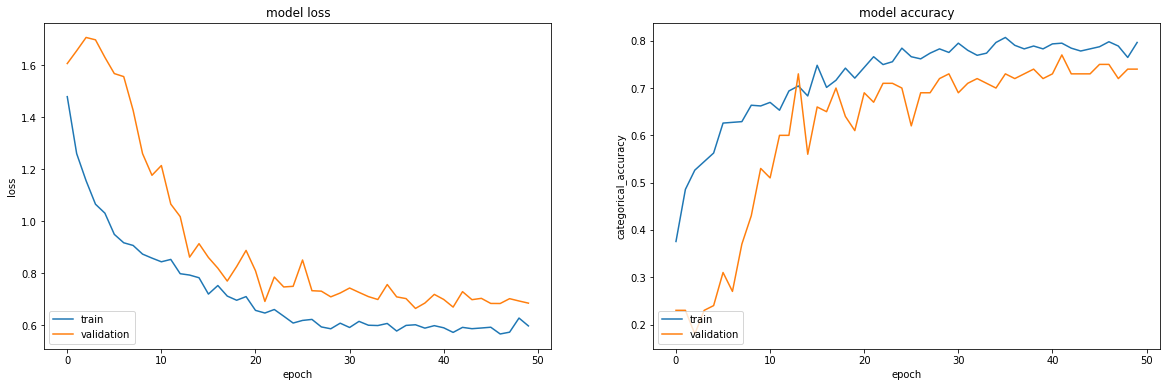

In [20]:

#Hyperparameters
batch_size = 32
num_epochs = 50

print ('# batch_size =', batch_size)
print ('# epochs =', num_epochs)

experiment_name = 'Conv2D_LSTM2D'
experiment_number = 'Experiment_32'
img_x = 80
img_y = 80
img_idx = range(0, 29)
input_shape = (len(img_idx),img_x,img_y,3)

#Data Generator
train_generator,val_generator = data_generator(img_idx,img_x,img_y,batch_size)

#Create the model
model = conv2d_LSTM2D_1(input_shape,'Adam')
callbacks_list = define_checkpoint_callback()
steps_per_epoch, validation_steps = epoch_steps()

#Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
#Plot the results
modelplot(history)

## Experiment 33
<b>Conv2d + LSTM2D: </b> - 
All Images | Batch Size = 30 | Optimizer = Adam | Number of Epochs = 50

# batch_size = 30
# epochs = 50


2023-06-17 11:21:10.424004: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-06-17 11:21:10.424083: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 29, 78, 78, 8)    224       
 ibuted)                                                         
                                                                 
 batch_normalization (BatchN  (None, 29, 78, 78, 8)    32        
 ormalization)                                                   
                                                                 
 time_distributed_1 (TimeDis  (None, 29, 76, 76, 16)   1168      
 tributed)                                                       
                                                                 
 batch_normalization_1 (Batc  (None, 29, 76, 76, 16)   64        
 hNormalization)                                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 74, 74, 8)         6

2023-06-17 11:21:15.460118: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


23/23 [==============================] - ETA: 0s - loss: 1.5154 - categorical_accuracy: 0.3167
Epoch 00001: saving model to model_Conv2D_LSTM2D_2023-06-1711_20_50.919361/Experiment_33-00001-1.51543-0.31674-1.60311-0.23000.h5
23/23 [==============================] - 46s 2s/step - loss: 1.5154 - categorical_accuracy: 0.3167 - val_loss: 1.6031 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/50
23/23 [==============================] - ETA: 0s - loss: 1.2890 - categorical_accuracy: 0.4389
Epoch 00002: saving model to model_Conv2D_LSTM2D_2023-06-1711_20_50.919361/Experiment_33-00002-1.28896-0.43891-1.65949-0.20000.h5
23/23 [==============================] - 41s 2s/step - loss: 1.2890 - categorical_accuracy: 0.4389 - val_loss: 1.6595 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/50
23/23 [==============================] - ETA: 0s - loss: 1.1508 - categorical_accuracy: 0.5370
Epoch 00003: saving model to model_Conv2D_LSTM2D_2023-06-1711_20_50.919361/Experiment_33-00003-1.1507

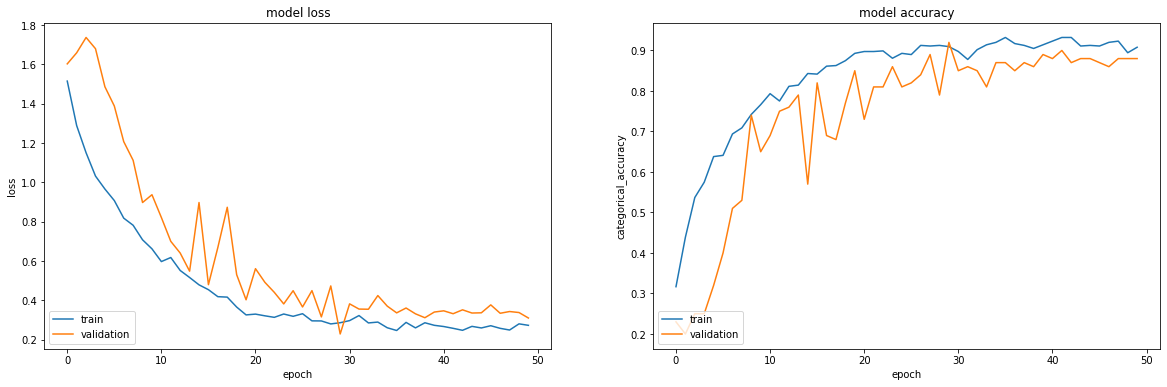

In [18]:

#Hyperparameters
batch_size = 30
num_epochs = 50

print ('# batch_size =', batch_size)
print ('# epochs =', num_epochs)

experiment_name = 'Conv2D_LSTM2D'
experiment_number = 'Experiment_33'
img_x = 80
img_y = 80
img_idx = range(0, 29)
input_shape = (len(img_idx),img_x,img_y,3)

#Data Generator
train_generator,val_generator = data_generator(img_idx,img_x,img_y,batch_size)

#Create the model
model = conv2d_LSTM2D_1(input_shape,'Adam')
callbacks_list = define_checkpoint_callback()
steps_per_epoch, validation_steps = epoch_steps()

#Fit the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
#Plot the results
modelplot(history)